In [1]:
# ==================== VAE for DDoS Synthetic Data =====================
# Generates synthetic tabular data from your selected features
# Compatible with your existing ddos.csv setup (same preprocessing)

!pip install -q pandas scikit-learn torch matplotlib

import os, time, pathlib
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
import shutil
from google.colab import drive
drive.mount("/content/gdrive")
# Change the code below if the path to the dataset is different for you.
shutil.unpack_archive("/content/gdrive/MyDrive/ddos_dataset.zip", "/tmp/")

Mounted at /content/gdrive


In [5]:
# 1) CSV yükle (yolunu değiştir)
CSV_PATH = r"/tmp/dataset_sdn.csv"   # kendi dosya yolunu yaz
df = pd.read_csv(CSV_PATH, low_memory=False)
print(df.shape)
display(df.head())

(104345, 23)


,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0


In [6]:

# ---------------- CONFIG ----------------

SELECTED_FEATURES = [
    'dt','pktcount','bytecount','dur','tot_dur',
    'packetins','pktperflow','byteperflow','pktrate','tx_bytes'
]
TARGET_COL = None
MODEL_DIR = "/content/drive/MyDrive/vae_ddos_checkpoints"
EPOCHS = 100
BATCH_SIZE = 128
LR = 1e-3
LATENT_DIM = 64
HIDDEN_DIM = 128
SEED = 42

In [7]:
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ========== Load and preprocess ==========
df = pd.read_csv(CSV_PATH, low_memory=False)
if TARGET_COL is None:
    for cand in ['label','Label','class','Class','attack','Attack','target','Target','flow_label']:
        if cand in df.columns:
            TARGET_COL = cand
            break
    if TARGET_COL is None:
        TARGET_COL = df.columns[-1]
print("Using target column:", TARGET_COL)

use_cols = [c for c in SELECTED_FEATURES if c in df.columns] + [TARGET_COL]
df_sel = df[use_cols].dropna().reset_index(drop=True)

if df_sel[TARGET_COL].dtype != int:
    df_sel[TARGET_COL] = pd.factorize(df_sel[TARGET_COL])[0]

X = df_sel[SELECTED_FEATURES].astype(float).values
y = df_sel[TARGET_COL].astype(int).values.reshape(-1,1)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val = train_test_split(X_scaled, test_size=0.1, random_state=SEED)
print("Train:", X_train.shape, "Val:", X_val.shape)

Device: cuda
Using target column: label
Train: (93910, 10) Val: (10435, 10)


In [8]:
# Torch Dataset
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

train_loader = torch.utils.data.DataLoader(TabularDataset(X_train), batch_size=BATCH_SIZE, shuffle=True)

In [9]:
# ========== Define VAE ==========
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.logvar = nn.Linear(hidden_dim // 2, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # scaled [0,1]
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# Loss: reconstruction + KL divergence
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss, recon_loss, kl_loss

vae = VAE(input_dim=X_scaled.shape[1], hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=LR)

In [10]:
# ========== Training Loop ==========
# inside training loop, compute kl_weight as schedule
total_steps = EPOCHS * len(train_loader)
global_step = 0
warmup_steps = int(0.25 * total_steps)

history = {'total': [], 'recon': [], 'kl': []}
vae.train()

for epoch in range(1, EPOCHS + 1):
    total_loss = recon_loss_total = kl_loss_total = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        recon, mu, logvar = vae(batch)
        recon_loss = nn.functional.mse_loss(recon, batch, reduction='mean')
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        # linear annealing from 0.0 -> 1.0 over first warmup_steps
        kl_weight = min(1.0, global_step / max(1, warmup_steps))
        loss = recon_loss + kl_weight * kl_loss  # annealed total loss

        loss.backward()
        optimizer.step()
        global_step += 1

        total_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()

    # epoch history
    history['total'].append(total_loss / len(train_loader))
    history['recon'].append(recon_loss_total / len(train_loader))
    history['kl'].append(kl_loss_total / len(train_loader))

    print(f"Epoch {epoch}/{EPOCHS} | Total: {history['total'][-1]:.4f} "
          f"| Recon: {history['recon'][-1]:.4f} | KL: {history['kl'][-1]:.4f}")



# Save model
pathlib.Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)
torch.save({'model_state': vae.state_dict(), 'scaler': scaler}, os.path.join(MODEL_DIR, 'vae_ddos.pt'))
print("Model saved to:", MODEL_DIR)

Epoch 1/100 | Total: 0.0183 | Recon: 0.0157 | KL: 0.1351
Epoch 2/100 | Total: 0.0095 | Recon: 0.0049 | KL: 0.0791
Epoch 3/100 | Total: 0.0107 | Recon: 0.0045 | KL: 0.0625
Epoch 4/100 | Total: 0.0123 | Recon: 0.0048 | KL: 0.0537
Epoch 5/100 | Total: 0.0141 | Recon: 0.0055 | KL: 0.0479
Epoch 6/100 | Total: 0.0158 | Recon: 0.0062 | KL: 0.0433
Epoch 7/100 | Total: 0.0174 | Recon: 0.0070 | KL: 0.0398
Epoch 8/100 | Total: 0.0187 | Recon: 0.0078 | KL: 0.0364
Epoch 9/100 | Total: 0.0201 | Recon: 0.0087 | KL: 0.0335
Epoch 10/100 | Total: 0.0213 | Recon: 0.0096 | KL: 0.0308
Epoch 11/100 | Total: 0.0223 | Recon: 0.0103 | KL: 0.0285
Epoch 12/100 | Total: 0.0233 | Recon: 0.0110 | KL: 0.0266
Epoch 13/100 | Total: 0.0242 | Recon: 0.0117 | KL: 0.0249
Epoch 14/100 | Total: 0.0250 | Recon: 0.0126 | KL: 0.0231
Epoch 15/100 | Total: 0.0259 | Recon: 0.0136 | KL: 0.0213
Epoch 16/100 | Total: 0.0267 | Recon: 0.0146 | KL: 0.0197
Epoch 17/100 | Total: 0.0275 | Recon: 0.0155 | KL: 0.0182
Epoch 18/100 | Total: 0

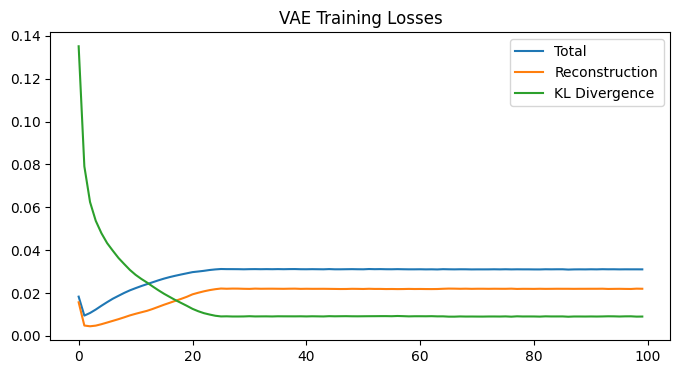

In [11]:
# Plot training losses
plt.figure(figsize=(8,4))
plt.plot(history['total'], label='Total')
plt.plot(history['recon'], label='Reconstruction')
plt.plot(history['kl'], label='KL Divergence')
plt.legend()
plt.title("VAE Training Losses")
plt.show()



In [12]:
# check mu and logvar stats on a batch
vae.eval()
with torch.no_grad():
    sample_batch = torch.tensor(X_train[:512], dtype=torch.float32).to(device)
    mu, logvar = vae.encode(sample_batch)
    print("mu mean/std:", mu.mean().item(), mu.std().item())
    print("logvar mean:", logvar.mean().item(), "logvar std:", logvar.std().item())

mu mean/std: 0.0008849154110066593 0.1035531610250473
logvar mean: -0.01890677586197853 logvar std: 0.15547457337379456


In [13]:
recon, mu, logvar = vae(sample_batch)
mse = ((recon - sample_batch)**2).mean().item()
print("batch recon mse:", mse)


batch recon mse: 0.021609008312225342


In [14]:
# ========== Sampling Synthetic Data ==========
vae.eval()
def sample_synthetic_vae(n_samples=1000):
    with torch.no_grad():
        z = torch.randn(n_samples, LATENT_DIM).to(device)
        syn = vae.decode(z).cpu().numpy()
    return scaler.inverse_transform(syn)

synthetic_data = sample_synthetic_vae(1000)
print("Generated synthetic samples:", synthetic_data.shape)

syn_df = pd.DataFrame(synthetic_data, columns=SELECTED_FEATURES)
SYNTHETIC_PATH = os.path.join(MODEL_DIR, "synthetic_vae_ddos.csv")
syn_df.to_csv(SYNTHETIC_PATH, index=False)
print("Saved synthetic CSV:", SYNTHETIC_PATH)

Generated synthetic samples: (1000, 10)
Saved synthetic CSV: /content/drive/MyDrive/vae_ddos_checkpoints/synthetic_vae_ddos.csv


In [15]:
# --- Show first 10 synthetic samples ---
print("\nFirst 10 rows of synthetic VAE-generated data:\n")
display(syn_df.head(10))


First 10 rows of synthetic VAE-generated data:



,dt,pktcount,bytecount,dur,tot_dur,packetins,pktperflow,byteperflow,pktrate,tx_bytes
0,14830.177734,118189.218750,121292424.0,386.177582,3.861263e+11,4197.210938,8926.342773,9.427964e+06,297.377655,99480720.0
1,17572.826172,38036.843750,13941589.0,274.912262,2.755620e+11,5984.859375,5118.294922,2.303388e+06,170.851501,88293632.0
2,25208.933594,30831.619141,7590917.0,356.339447,3.571756e+11,5703.650391,3501.386719,8.148789e+05,117.120872,102875112.0
3,14315.519531,45115.542969,22107450.0,243.872879,2.445064e+11,5920.030273,6335.468262,3.776216e+06,211.473846,83328544.0
4,11276.999023,69340.554688,55484436.0,245.240997,2.458491e+11,5198.921387,8742.147461,7.637454e+06,291.638214,84073080.0
5,20781.554688,33767.824219,10061731.0,305.211395,3.057624e+11,5908.182617,4443.721191,1.592693e+06,148.181839,92787704.0
6,19649.519531,35636.605469,11537703.0,295.552612,2.957968e+11,5946.594727,4671.448730,1.827593e+06,156.046692,91968424.0
7,11213.840820,106286.117188,105578016.0,297.046143,2.974877e+11,4618.230957,9855.534180,1.015403e+07,328.741364,94370512.0
8,15836.906250,117788.585938,121273496.0,396.998322,3.977585e+11,4315.870117,8285.986328,8.550006e+06,276.062988,102495880.0
9,29736.796875,24979.468750,4410147.5,422.510437,4.230753e+11,5222.718262,2973.113037,6.199782e+05,98.932579,109035520.0



=== Real vs Synthetic Statistical Metrics ===


,Feature,KS_stat,KS_p,KL_divergence,Wasserstein_distance
9,tx_bytes,0.654310,0.000000e+00,3.828259,1.046745e+08
5,packetins,0.610869,0.000000e+00,10.745640,3.610081e+03
4,tot_dur,0.448806,1.227816e-182,0.000119,1.247915e+11
3,dur,0.447732,1.014543e-181,7.850725,1.247955e+02
0,dt,0.385730,3.410762e-133,6.170736,5.226596e+03
2,bytecount,0.381650,2.683427e-130,2.791948,1.187725e+07
7,byteperflow,0.375533,5.062107e-126,1.711777,2.627905e+06
8,pktrate,0.374996,1.190374e-125,5.121543,1.036691e+02
6,pktperflow,0.374517,2.550955e-125,4.244269,3.107202e+03
1,pktcount,0.374203,4.205191e-125,5.038563,2.201981e+04


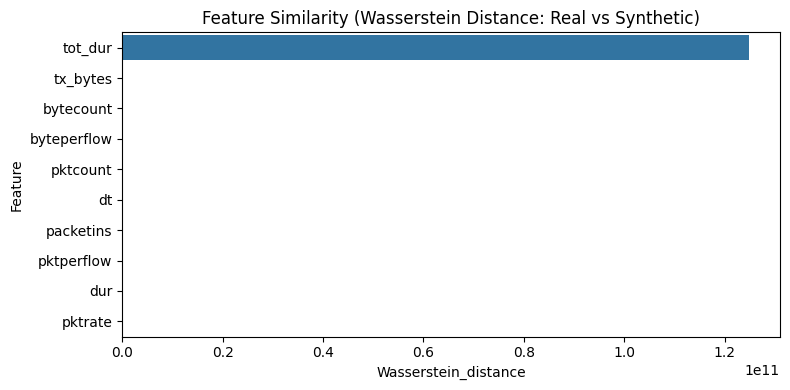

In [17]:
# --- Statistical similarity tests: real vs synthetic ---
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, entropy, wasserstein_distance
import matplotlib.pyplot as plt
import seaborn as sns

# 'df_sel' orijinal dataset’in preprocess edilmiş haliydi:
real_df = df_sel [SELECTED_FEATURES].reset_index(drop=True)
synthetic_df = syn_df.reset_index(drop=True)

def kl_divergence_hist(p, q, bins=100):
    """Histogram tabanlı KL Divergence"""
    p_hist, bin_edges = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bin_edges, density=True)
    p_hist += 1e-10
    q_hist += 1e-10
    return entropy(p_hist, q_hist)

results = []
for col in SELECTED_FEATURES:
    real_col = real_df[col].values
    syn_col = synthetic_df[col].values

    ks_stat, ks_p = ks_2samp(real_col, syn_col)
    kl_div = kl_divergence_hist(real_col, syn_col)
    w_dist = wasserstein_distance(real_col, syn_col)

    results.append({
        "Feature": col,
        "KS_stat": ks_stat,
        "KS_p": ks_p,
        "KL_divergence": kl_div,
        "Wasserstein_distance": w_dist
    })

results_df = pd.DataFrame(results)
print("\n=== Real vs Synthetic Statistical Metrics ===")
display(results_df.sort_values("KS_stat", ascending=False))

# --- Plot Wasserstein distances ---
plt.figure(figsize=(8,4))
sns.barplot(
    x="Wasserstein_distance",
    y="Feature",
    data=results_df.sort_values("Wasserstein_distance", ascending=False)
)
plt.title("Feature Similarity (Wasserstein Distance: Real vs Synthetic)")
plt.tight_layout()
plt.show()

In [18]:
# --- Diagnostic checks ---
import numpy as np, pandas as pd
pd.set_option('display.float_format', lambda x: '%.6g' % x)

print("SELECTED_FEATURES length:", len(SELECTED_FEATURES))
print("Scaler attributes sizes (if exist):")
for attr in ['n_features_in_', 'data_min_', 'data_max_', 'scale_', 'min_']:
    if hasattr(scaler, attr):
        val = getattr(scaler, attr)
        try:
            print(f"  {attr}: shape {np.shape(val)}")
        except:
            print(f"  {attr}: {val}")

# Check a few scaler stats (first 10)
if hasattr(scaler, 'data_min_'):
    print("\nscaler.data_min_ (first 10):", scaler.data_min_[:min(10,len(scaler.data_min_))])
if hasattr(scaler, 'data_max_'):
    print("scaler.data_max_ (first 10):", scaler.data_max_[:min(10,len(scaler.data_max_))])

# Show real data summaries (the df_sel you used to train VAE)
real_df = df_sel[SELECTED_FEATURES].reset_index(drop=True)
print("\nReal features describe (head):")
display(real_df.head(5))
display(real_df.describe().T[['min','25%','50%','75%','max','mean','std']])

# Show synthetic raw matrix stats (before inverse transform) and after if available
# If syn_np and syn_inv exist from your earlier block, use them, otherwise recreate quickly:
try:
    syn_np  # latent-output scaled (0-1)
except NameError:
    # produce a small sample to inspect (no need to use whole 5000 here)
    vae.eval()
    with torch.no_grad():
        z = torch.randn(1000, LATENT_DIM, device=device)
        if hasattr(vae, 'decode'):
            syn_tensor = vae.decode(z)
        else:
            syn_tensor = vae.decoder(z)
        syn_np = syn_tensor.cpu().numpy()

print("\nSYN (raw decoded) stats (first 10 features):")
print(" shape:", syn_np.shape)
print(" min per-col (first 10):", np.min(syn_np, axis=0)[:min(10,syn_np.shape[1])])
print(" max per-col (first 10):", np.max(syn_np, axis=0)[:min(10,syn_np.shape[1])])
print(" mean per-col (first 10):", np.mean(syn_np, axis=0)[:min(10,syn_np.shape[1])])

# If scaler.data_min_ shaped differently than features, print info
if hasattr(scaler, 'data_min_') and scaler.data_min_.shape[0] != syn_np.shape[1]:
    print("\n>>> WARNING: scaler fitted dimension", scaler.data_min_.shape[0],
          "but generator outputs", syn_np.shape[1])

# Attempt safe inverse transform: use scaler.data_min_/data_max_ first n features
n_feats = len(SELECTED_FEATURES)
if hasattr(scaler, 'data_min_') and hasattr(scaler, 'data_max_'):
    dm = scaler.data_min_[:n_feats]
    dM = scaler.data_max_[:n_feats]
    syn_inv_try = syn_np[:, :n_feats] * (dM - dm) + dm
    print("\nsyn_inv_try stats (first 10 cols):")
    print(" min:", syn_inv_try.min(axis=0)[:min(10,n_feats)])
    print(" max:", syn_inv_try.max(axis=0)[:min(10,n_feats)])
else:
    print("\nScaler lacks data_min_/data_max_. Can't safe inverse without refit.")


SELECTED_FEATURES length: 10
Scaler attributes sizes (if exist):
  n_features_in_: shape ()
  data_min_: shape (10,)
  data_max_: shape (10,)
  scale_: shape (10,)
  min_: shape (10,)

scaler.data_min_ (first 10): [ 2.48800000e+03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  4.00000000e+00 -1.30933000e+05 -1.46442594e+08
 -4.36500000e+03  2.52700000e+03]
scaler.data_max_ (first 10): [4.29350000e+04 2.60006000e+05 1.47128002e+08 1.88100000e+03
 1.88000000e+12 2.52240000e+04 1.91900000e+04 1.49538720e+07
 6.39000000e+02 1.26998197e+09]

Real features describe (head):


,dt,pktcount,bytecount,dur,tot_dur,packetins,pktperflow,byteperflow,pktrate,tx_bytes
0,11425,45304,48294064,100,1.01e+11,1943,13535,14428310,451,143928631
1,11605,126395,134737070,280,2.81e+11,1943,13531,14424046,451,3842
2,11425,90333,96294978,200,2.01e+11,1943,13534,14427244,451,3795
3,11425,90333,96294978,200,2.01e+11,1943,13534,14427244,451,3688
4,11425,90333,96294978,200,2.01e+11,1943,13534,14427244,451,3413


,min,25%,50%,75%,max,mean,std
dt,2488,7098,11905,29952,42935,17927.5,11977.6
pktcount,0,808,42828,94796,260006,52861,52023.2
bytecount,0,79576,6.47193e+06,7.62035e+07,1.47128e+08,3.81866e+07,4.87775e+07
dur,0,127,251,412,1881,321.497,283.518
tot_dur,0,1.27e+11,2.52e+11,4.13e+11,1.88e+12,3.21886e+11,2.83403e+11
packetins,4,1943,3024,7462,25224,5200.38,5257
pktperflow,-130933,29,8305,10017,19190,6381.72,7404.78
byteperflow,-1.46443e+08,2842,552168,9.72811e+06,1.49539e+07,4.71615e+06,7.56012e+06
pktrate,-4365,0,276,333,639,212.211,246.855
tx_bytes,2527,4743,4.21961e+06,1.3564e+08,1.26998e+09,9.32526e+07,1.51938e+08



SYN (raw decoded) stats (first 10 features):
 shape: (1000, 10)
 min per-col (first 10): [0.19872904 0.04995637 0.01368607 0.12025958 0.12061967 0.11143169
 0.87377846 0.9024515  0.8744523  0.06101415]
 max per-col (first 10): [0.7689239  0.5198394  0.9220597  0.79752266 0.7976745  0.24064866
 0.9414475  0.9731621  0.9414837  0.12564468]
 mean per-col (first 10): [0.38859713 0.21412905 0.26844642 0.17656696 0.1769857  0.21036983
 0.91284627 0.9345769  0.91302234 0.07483184]

syn_inv_try stats (first 10 cols):
 min: [ 1.05259934e+04  1.29889569e+04  2.01360348e+06  2.26208276e+02
  2.26764979e+11  2.81430717e+03  2.41244112e+02 -7.90108711e+05
  1.07592738e+01  7.74892426e+07]
 max: [3.35886641e+04 1.35161365e+05 1.35660804e+08 1.50014013e+03
 1.49962802e+12 6.07315913e+03 1.03999225e+04 1.06223321e+07
 3.46184317e+02 1.59568693e+08]


In [ ]:
# === VAE: generate 5k synthetic samples, compute KS/KL/Wasserstein, run TSTR ===
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, entropy, wasserstein_distance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch


In [ ]:
# --- Settings
N_SYN = 5000
LATENT_DIM = LATENT_DIM  # kullandığın latent boyutu
SELECTED_FEATURES = SELECTED_FEATURES  # global değişkenler
TARGET_COL = TARGET_COL
device = next(vae.parameters()).device

# --- 1) Generate synthetic samples via VAE decoder (PyTorch) ---
vae.eval()
with torch.no_grad():
    z = torch.randn(N_SYN, LATENT_DIM, device=device)
    # decoder expects torch tensor; call vae.decode
    if hasattr(vae, 'decode'):
        syn_tensor = vae.decode(z)
    else:
        # fallback: if your VAE defines forward differently, use: vae.decoder(z)
        syn_tensor = vae.decoder(z)
    syn_np = syn_tensor.cpu().numpy()

# inverse transform to original scale using scaler (fitted earlier on SELECTED_FEATURES)
# NOTE: scaler was fit on the feature matrix X (not including label)
syn_inv = scaler.inverse_transform(syn_np)  # shape (N_SYN, n_features)
synthetic_df = pd.DataFrame(syn_inv, columns=SELECTED_FEATURES)

# --- 2) Make sure real dataframe is available: use df_sel (the one used to train VAE)
real_df = df_sel.reset_index(drop=True)  # df_sel must exist from previous preprocessing
real_features = real_df[SELECTED_FEATURES].reset_index(drop=True)

print("Real shape:", real_features.shape, "Synthetic shape:", synthetic_df.shape)

# --- 3) Similarity metrics per feature: KS, KL, Wasserstein
def kl_divergence_discrete(a, b, bins=100):
    pa, edges = np.histogram(a, bins=bins, density=True)
    pb, _ = np.histogram(b, bins=edges, density=True)
    pa = pa + 1e-10
    pb = pb + 1e-10
    return entropy(pa, pb)

metrics = []
for col in SELECTED_FEATURES:
    real_col = real_features[col].values
    syn_col = synthetic_df[col].values

    ks_stat, ks_p = ks_2samp(real_col, syn_col)
    kl = kl_divergence_discrete(real_col, syn_col, bins=100)
    w = wasserstein_distance(real_col, syn_col)

    metrics.append({
        'Feature': col,
        'KS_stat': float(ks_stat),
        'KS_pvalue': float(ks_p),
        'KL_divergence': float(kl),
        'Wasserstein_distance': float(w)
    })

metrics_df = pd.DataFrame(metrics).sort_values('KS_stat')
print("\nFeature similarity metrics (sorted by KS):")
display(metrics_df)


Real shape: (104345, 10) Synthetic shape: (5000, 10)

Feature similarity metrics (sorted by KS):


,Feature,KS_stat,KS_pvalue,KL_divergence,Wasserstein_distance
1,pktcount,0.345122,0.0,4.843317,2.043748e+04
2,bytecount,0.354336,0.0,1.813337,1.013674e+07
6,pktperflow,0.371314,0.0,4.864202,3.262404e+03
8,pktrate,0.371314,0.0,5.687700,1.088087e+02
0,dt,0.381195,0.0,5.716586,5.012677e+03
3,dur,0.450630,0.0,7.248962,1.229908e+02
4,tot_dur,0.451107,0.0,0.000095,1.230221e+11
7,byteperflow,0.541871,0.0,3.240701,2.909391e+06
5,packetins,0.589818,0.0,9.172984,3.519706e+03
9,tx_bytes,0.654652,0.0,3.839704,1.050327e+08


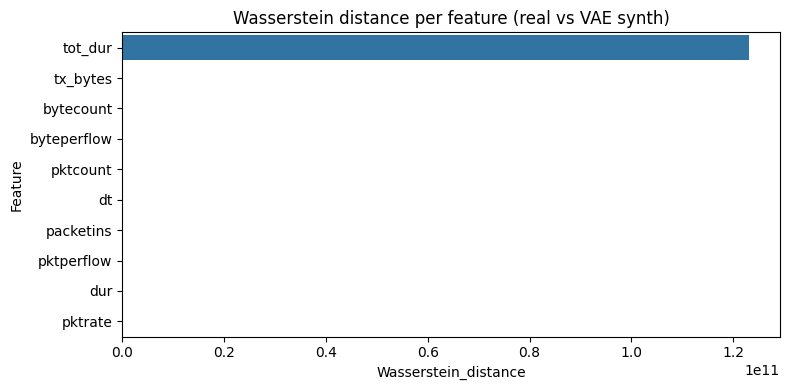

In [ ]:
# Optional: quick bar plot (Wasserstein)
plt.figure(figsize=(8,4))
sns.barplot(x='Wasserstein_distance', y='Feature', data=metrics_df.sort_values('Wasserstein_distance', ascending=False))
plt.title('Wasserstein distance per feature (real vs VAE synth)')
plt.tight_layout()
plt.show()


=== TSTR (Train on Synthetic w/ pseudo-labels -> Test on Real) ===
Accuracy on real data: 0.3909
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     63561
           1     0.3909    1.0000    0.5620     40784

    accuracy                         0.3909    104345
   macro avg     0.1954    0.5000    0.2810    104345
weighted avg     0.1528    0.3909    0.2197    104345



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


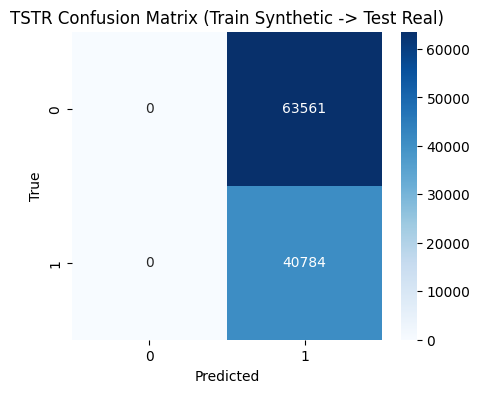

In [ ]:
# --- 4) TSTR: Train on Synthetic (pseudo-labeled) -> Test on Real
# Since VAE wasn't conditional, synthetic samples don't have labels.
# We'll produce pseudo-labels by predicting with a classifier trained on real data.
# Step A: Train a classifier on REAL to create pseudo-labels for synthetic
X_real = real_features.copy()
y_real = real_df[TARGET_COL].astype(int).reset_index(drop=True)

clf_real = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf_real.fit(X_real, y_real)
# pseudo-label synthetic
y_synth_pseudo = clf_real.predict(synthetic_df)

# Build synthetic-labeled dataset
X_synth = synthetic_df.copy()
y_synth = pd.Series(y_synth_pseudo, name=TARGET_COL)

# Now perform TSTR properly: train classifier on synthetic (pseudo-labels), test on real
clf_tstr = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf_tstr.fit(X_synth, y_synth)
y_pred_on_real = clf_tstr.predict(X_real)

acc_tstr = accuracy_score(y_real, y_pred_on_real)
print(f"\n=== TSTR (Train on Synthetic w/ pseudo-labels -> Test on Real) ===")
print(f"Accuracy on real data: {acc_tstr:.4f}")
print(classification_report(y_real, y_pred_on_real, digits=4))

# Confusion matrix
cm = confusion_matrix(y_real, y_pred_on_real)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('TSTR Confusion Matrix (Train Synthetic -> Test Real)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

In [ ]:
# --- 5) Additional evaluation: classifier two-sample test (can real and synthetic be separated?)
# Build combined dataset and try to classify real vs synthetic
real_label_marker = np.ones(len(X_real), dtype=int)
synth_label_marker = np.zeros(len(X_synth), dtype=int)
X_comb = pd.concat([X_real, X_synth], ignore_index=True)
y_comb = np.concatenate([real_label_marker, synth_label_marker])

# simple RF to distinguish real vs synthetic
clf_two_sample = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf_two_sample.fit(X_comb, y_comb)
yhat = clf_two_sample.predict(X_comb)
acc_two_sample = accuracy_score(y_comb, yhat)
print(f"\nClassifier two-sample (train+test on combined): accuracy (how separable) = {acc_two_sample:.4f}")
# Lower accuracy -> synthetic more indistinguishable

# Print summary table
summary = {
    'TSTR_acc': acc_tstr,
    'TwoSample_acc': acc_two_sample
}
print("\nSummary metrics:", summary)


Classifier two-sample (train+test on combined): accuracy (how separable) = 1.0000

Summary metrics: {'TSTR_acc': 0.3908572523839187, 'TwoSample_acc': 1.0}
